In [1]:

!pip install gymnasium shimmy stable-baselines3[extra] matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import os
from datetime import datetime
from gymnasium.wrappers import RecordVideo
from stable_baselines3 import SAC
import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback
import shutil
import numpy as np
import gymnasium as gym

video_folder = "/content/drive/My Drive/RL"
os.makedirs(video_folder, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
video_filename = f"rl-video-{timestamp}.mp4"
video_file_path = os.path.join(video_folder, video_filename)

def video_trigger(episode_id):
    return episode_id == 0

env = RecordVideo(
    gym.make("Pendulum-v1", render_mode="rgb_array"),
    video_folder=video_folder,
    episode_trigger=video_trigger
)
print(f"Video will be saved to: {video_file_path}")


Video will be saved to: /content/drive/My Drive/RL/rl-video-20241211_100230.mp4


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/drive/My Drive/RL folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [5]:
class RewardCallback(BaseCallback):
    """
    自定义回调函数，用于记录每个 episode 的奖励。
    """
    def __init__(self, verbose=0):
        super(RewardCallback, self).__init__(verbose)
        self.episode_rewards = []

    def _on_step(self):

        if 'episode' in self.locals['infos'][0]:
            self.episode_rewards.append(self.locals['infos'][0]['episode']['r'])
        return True


In [6]:
model = SAC("MlpPolicy", env, verbose=1, batch_size=256,
    buffer_size=200000 )

reward_callback = RewardCallback()

model.learn(total_timesteps=200000, log_interval=10, callback=reward_callback)

model.save("sac_pendulum")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.38e+03 |
| time/              |           |
|    episodes        | 10        |
|    fps             | 54        |
|    time_elapsed    | 36        |
|    total_timesteps | 2000      |
| train/             |           |
|    actor_loss      | 55.4      |
|    critic_loss     | 0.154     |
|    ent_coef        | 0.583     |
|    ent_coef_loss   | -0.691    |
|    learning_rate   | 0.0003    |
|    n_updates       | 1899      |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.03e+03 |
| time/              |           |
|    episodes        | 20        |
|    fps             | 55        |
|    time_elapsed    | 71        |
|    total_timesteps | 4000      |
| train/             |           |
|    actor_loss      | 81        |
|    critic_loss    

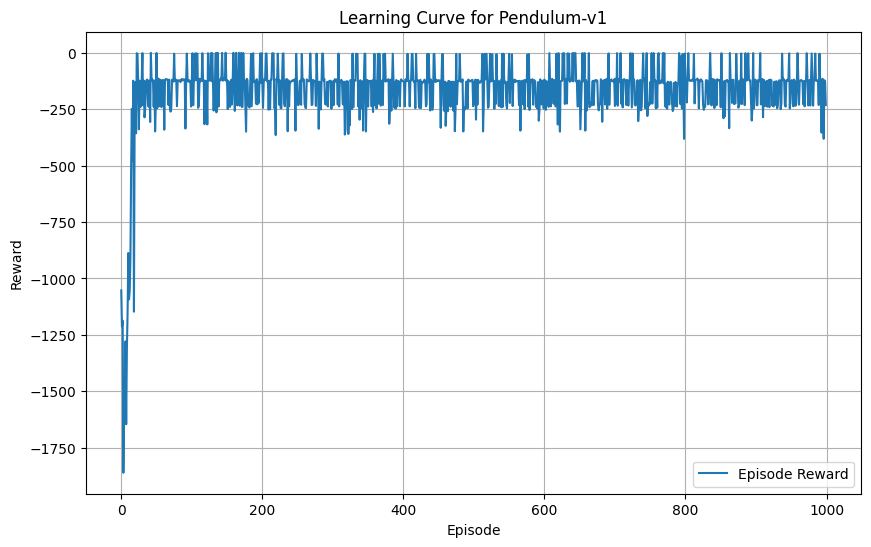

Learning curve saved to: /content/drive/My Drive/RL/learning_curve1.png


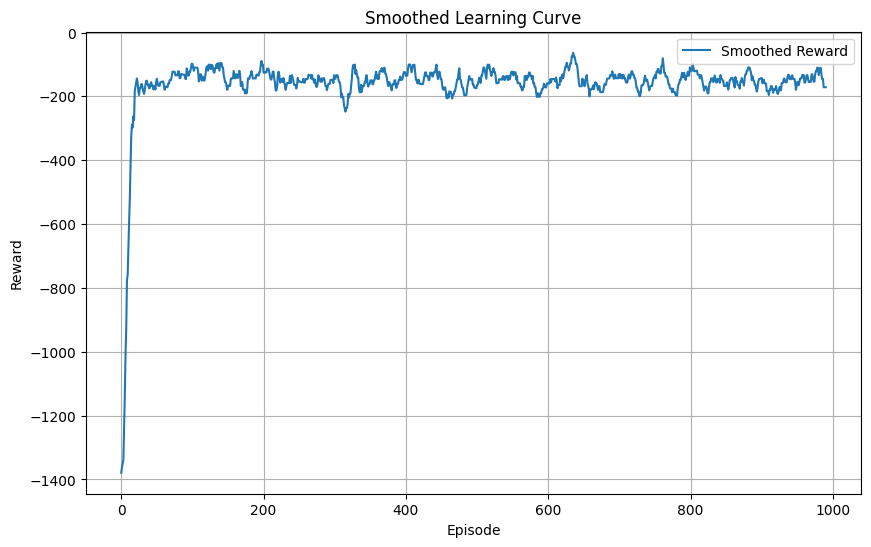

In [11]:

plt.figure(figsize=(10, 6))
plt.plot(reward_callback.episode_rewards, label='Episode Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Learning Curve for Pendulum-v1')
plt.legend()
plt.grid()

video_folder = "/content/drive/My Drive/RL"
save_path = f"{video_folder}/learning_curve1.png"
plt.savefig(save_path, dpi=300)
plt.show()

print(f"Learning curve saved to: {save_path}")

def smooth(data, window_size):
    """滑动平均平滑曲线"""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

smoothed_rewards = smooth(reward_callback.episode_rewards, window_size=10)

plt.figure(figsize=(10, 6))
plt.plot(smoothed_rewards, label='Smoothed Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Smoothed Learning Curve')
plt.legend()
plt.grid()
plt.show()


In [8]:

model = SAC.load("sac_pendulum")

obs, info = env.reset()
for _ in range(1000):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    if done or truncated:
        obs, info = env.reset()

env.close()

video_files = sorted([f for f in os.listdir(video_folder) if f.endswith(".mp4")])
if video_files:
    original_video_path = os.path.join(video_folder, video_files[-1])
    print("Generated video path (default):", original_video_path)

    shutil.move(original_video_path, video_file_path)
    print("Renamed video path:", video_file_path)
else:
    print("No video files found in folder.")


Generated video path (default): /content/drive/My Drive/RL/rl-video-episode-98.mp4
Renamed video path: /content/drive/My Drive/RL/rl-video-20241211_100230.mp4


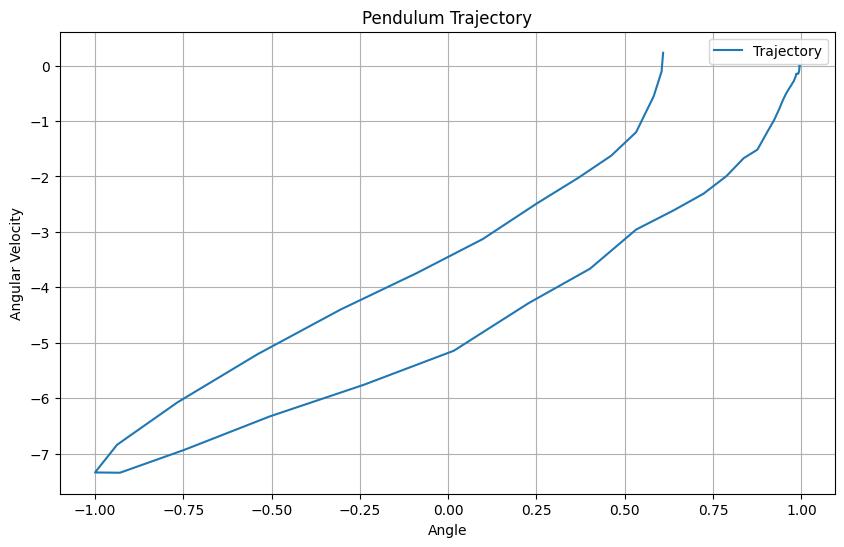

In [28]:
import matplotlib.pyplot as plt
import numpy as np

obs, info = env.reset()
states = []

for _ in range(1000):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    angle = obs[0]
    angular_velocity = obs[2]
    states.append((angle, angular_velocity))
    if done or truncated:
        break

states = np.array(states)

plt.figure(figsize=(10, 6))
plt.plot(states[:, 0], states[:, 1], label="Trajectory")
plt.title("Pendulum Trajectory")
plt.xlabel("Angle")
plt.ylabel("Angular Velocity")
plt.legend()
plt.grid()
plt.show()
